# A Pairs Trading strategy 

**Author:** Simão Moraes Sarmento <br /> 
**Contact:** simaosarmento@hotmail.com

## Dependencies

This notebook requires code from:

Python files:
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

Pickle files:
- pickle file containing pairs to be traded (obtained from running `PairsTrading_CommodityETFs-Clustering.ipynb`)

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples. Please look into the files menitoned above for more detailed info on how the functions are built.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# just set the seed for the random number generator
np.random.seed(107)

In [2]:
ticker_path = "data/etfs/pickle/ticker_segment_dict.pickle"
with open(ticker_path, 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)

### Import Classes

In [5]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

In [6]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()

# Retrieve prices data set

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [7]:
# intraday
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_from_2014_complete.pickle')

In [8]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            ('01-01-2012',
                                                             '31-12-2014'),
                                                            ('01-01-2015',
                                                             '31-12-2015'),
                                                            remove_nan=True)

Total of 116 tickers
Total of 95 tickers after removing tickers with Nan values


In [9]:
len(df_prices_train)+len(df_prices_test)

77916

# Load Pairs

In [10]:
with open('data/etfs/pickle/2012-2016/pairs_category_intraday.pickle', 'rb') as handle:
    pairs = pickle.load(handle)

In [12]:
len(pairs)

59

# Apply trading strategies

**Applying the fixed beta strategy in validation period**

In [13]:
train_val_split = '2014-01-01'

# intraday
n_years_val = round(len(df_prices_train[train_val_split:])/(240*78))

# interday
#n_years_val = round(len(df_prices_train)/(240))

n_years_val

1

In [14]:
train_results_without_costs, train_results_with_costs, performance_threshold_train = \
        trader.apply_trading_strategy(pairs, 
                                       'fixed_beta',
                                        2,#entry_multiplier,
                                        0,#exit_multiplier,
                                        test_mode=False,
                                        train_val_split=train_val_split
                                       )

sharpe_results_threshold_train_nocosts, cum_returns_threshold_train_nocosts = train_results_without_costs
sharpe_results_threshold_train_w_costs, cum_returns_threshold_train_w_costs = train_results_with_costs

 entry delay turned on.
Pair: 59/59

Average SR:  0.6871442072960724
Annual ROI:  6.93560901606296
67.79661016949153 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  2.1235740941136174
Autocorrelation:  0.036721027908408796
Daily Sharpe Ratio 0.13041442622047744
Total number of trades:  167
Positive trades:  104
Negative trades:  63
Max DD period: 3.0 days
Maximum drawdown of portfolio: -1.71%


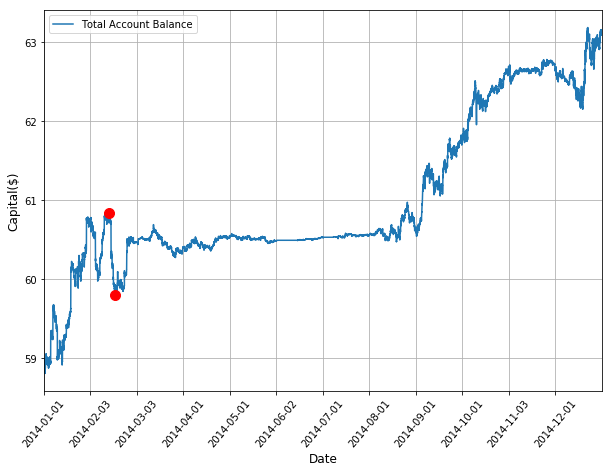

In [15]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_train_w_costs,
                                                  cum_returns_threshold_train_w_costs,
                                                  performance_threshold_train,
                                                  pairs, ticker_segment_dict,
                                                  n_years_val)

In [30]:
print('Corrected Annualized SR: {:.2f}'.format(0.13041442622047744*(252**0.5)))

Corrected Annualized SR: 2.07


Sharpe Ratio Distribution: 


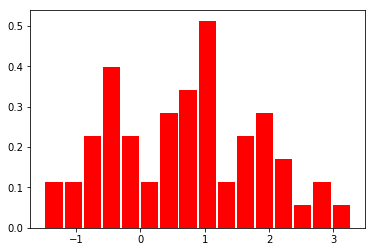

In [16]:
print('Sharpe Ratio Distribution: ')
n, bins, patches = plt.hist(sharpe_results_threshold_train_w_costs, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')

In [17]:
betas = list()
for i in range(len(pairs)):
    betas.append(pairs[i][2]['coint_coef'])
np.asarray(betas)

array([ 1.24525033,  2.4274593 ,  1.14350396,  1.15481571,  0.45903805,
        0.57130184,  0.83395672,  2.81857608,  0.24434038,  1.53438387,
        0.16867686,  0.36914727,  0.20139504,  0.75714618,  1.39133223,
        2.39499998,  0.23866385,  1.39881789,  1.67173893,  1.37550723,
        0.67513256,  1.05054659,  1.80493701,  5.4288947 ,  2.28250428,
        1.18180798,  1.83889542,  1.27400836,  1.55303747,  1.24726812,
        1.85944218,  1.22645846,  0.93119343,  1.62616958,  9.28888945,
       12.1799656 , 11.98787394,  1.6464653 ,  5.80386653,  1.93981938,
        0.56163217,  0.88791065,  0.56797951,  1.90691545,  0.29291248,
        3.28013448,  0.33238383,  6.97806628,  0.32686603,  2.18455585,
        3.39830113,  2.35621741,  1.92368515,  4.14116457,  1.07878942,
        2.14847196,  3.34185575,  2.3173922 ,  0.57458147])

# Out of Sample Analysis

In this section, we analyze the performance of the strategy in the validation dataset. 

We proceed with some data exploration analysis. For this purpose we will do the following:

- Analyze which percentage of the identified pairs are still cointegrated in the validation period.
- Analyze which percentage of pairs have positive returns, and how many of those are still cointegrated.
- Analyze how many new pais were not identified to be cointegrated up to the validation period.
- Run strategy for identified pairs in training period.

This analysis will help us getting some insight into how the cointegrated pairs vary from time to time, and therefore how we should allocate our resources to predict when pairs are not cointegrated anymore.

## Applying the Strategy out-of Sample

We might want to apply the strategy in all pairs identified. Or, instead, we might prefer to apply the strategy only on those pairs that turned out to be profitable. Let's compare how both approaches work:

In [18]:
# intraday
n_years_test = round(len(df_prices_test)/(240*78))

# interday
#n_years_test = round(len(df_prices_test)/(240))

n_years_test

1

### Approach 1: Unrestricted

**Basic Threshold Strategy**

In [19]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 59/59

Average SR:  0.5480486072570773
Annual ROI:  5.528993798883608
64.40677966101696 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  1.4345541023024349
Autocorrelation:  -0.12663599470071726
Daily Sharpe Ratio 0.08909977319384982
Total number of trades:  154
Positive trades:  112
Negative trades:  42
Max DD period: 2.0 days
Maximum drawdown of portfolio: -1.77%


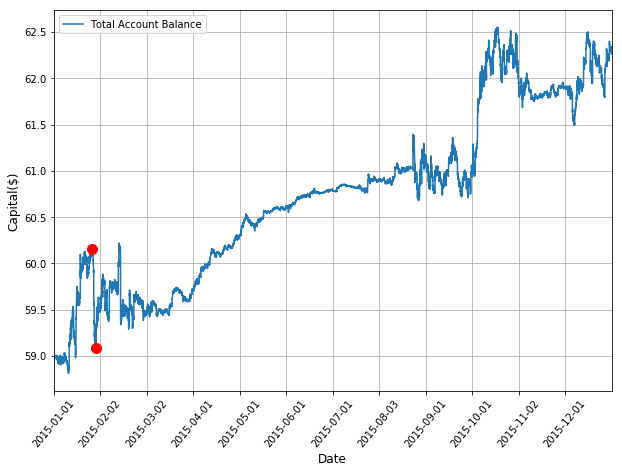

In [20]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  pairs, ticker_segment_dict,
                                                  n_years_test)

In [31]:
print('Corrected Annualized SR: {:.2f}'.format(0.08909977319384982*17.47))

Corrected Annualized SR: 1.56


### Approach 2: Keeping only pairs that had positive returns in the training period

In [21]:
cum_returns_threshold_train_w_costs = np.asarray(cum_returns_threshold_train_w_costs)
profitable_pairs_indices = np.argwhere(cum_returns_threshold_train_w_costs > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [22]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(profitable_pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 40/40

Average SR:  0.8992877194354391
Annual ROI:  9.381706380170328
85.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  2.2489359996714624
Autocorrelation:  -0.05254732263628954
Daily Sharpe Ratio 0.136640816352144
Total number of trades:  108
Positive trades:  89
Negative trades:  19
Max DD period: 11.0 days
Maximum drawdown of portfolio: -1.82%


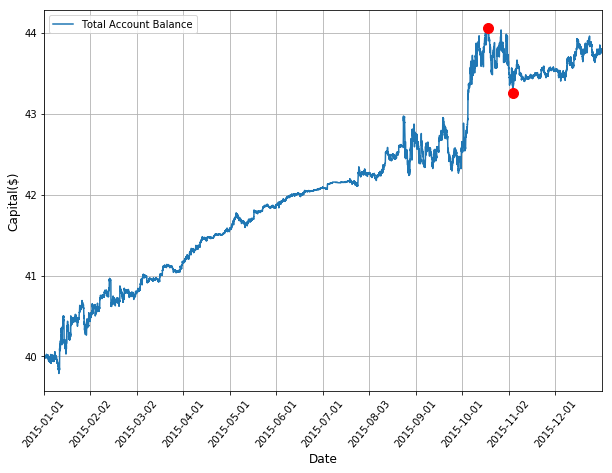

In [23]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  profitable_pairs, ticker_segment_dict,
                                                  n_years_test)

In [32]:
print('Corrected Annualized SR: {:.2f}'.format(0.136640816352144*17.47))

Corrected Annualized SR: 2.39


### Approach 3: Keeping only top 10 pairs

In [24]:
sharpe_results_threshold_train_w_costs = np.asarray(sharpe_results_threshold_train_w_costs)
sorted_pairs_indices = np.argsort(sharpe_results_threshold_train_w_costs)[::-1][:10]
top_10_pairs = [pairs[i] for i in sorted_pairs_indices.flatten()]

In [25]:
# sorting by returns seems to give better results

In [26]:
cum_returns_threshold_train_w_costs = np.asarray(cum_returns_threshold_train_w_costs)
sorted_pairs_indices = np.argsort(cum_returns_threshold_train_w_costs)[::-1][:10]
top_10_pairs = [pairs[i] for i in sorted_pairs_indices.flatten()]

In [27]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(top_10_pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 10/10

Average SR:  1.5155900958540924
Annual ROI:  17.808349803827394
90.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  3.677229249185371
Autocorrelation:  -0.06509842139503187
Daily Sharpe Ratio 0.2147284989604078
Total number of trades:  39
Positive trades:  36
Negative trades:  3
Max DD period: 3.0 days
Maximum drawdown of portfolio: -2.09%


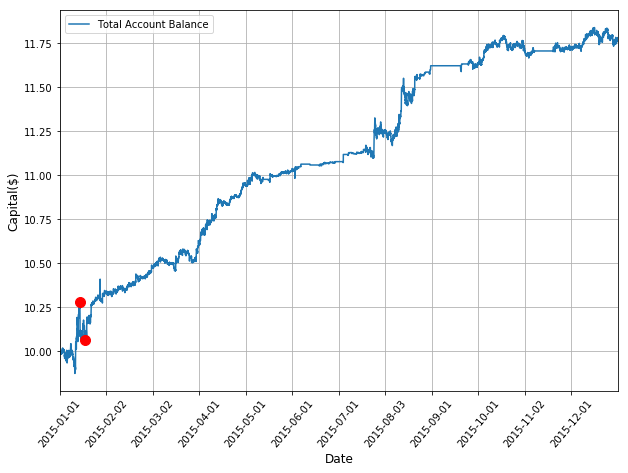

In [28]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  top_10_pairs, ticker_segment_dict,
                                                  n_years_test)

In [33]:
print('Corrected Annualized SR: {:.2f}'.format(0.2147284989604078*17.47))

Corrected Annualized SR: 3.75


# Validate the results

In [35]:
pairs_summary

,Leg1,Leg1_Segmt,Leg2,Leg2_Segmt,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive_trades,negative_trades,sharpe_result,positive_trades_per_pair_pct
0,BCM,Commodities: Broad Market,DJCI,Commodities: Broad Market,-3.771536,0.003212,392,111,0.297978,17,2,4.151694,89.473684
1,AGQ,Leveraged Commodities: Precious Metals Silver,GOEX,Equity: Global Gold Miners,-3.641566,0.005014,200,1581,0.443185,5,0,2.896705,100.000000
2,DBS,Commodities: Precious Metals Silver,GDXJ,Equity: Global Gold Miners,-3.453385,0.009268,468,1309,0.412529,4,0,1.682033,100.000000
3,OIH,Equity: Global Oil & Gas Equipment & Services,XOP,Equity: U.S. Oil & Gas Exploration & Production,-4.950624,0.000028,721,678,0.484755,1,0,1.407056,100.000000
4,XME,Equity: U.S. Metals & Mining,LIT,Equity: Global Metals & Mining,-4.331598,0.000391,749,516,0.392483,1,1,1.298808,50.000000
5,AGQ,Leveraged Commodities: Precious Metals Silver,GDXJ,Equity: Global Gold Miners,-3.998006,0.001421,425,1103,0.472849,2,0,1.232410,100.000000
6,GLTR,Commodities: Precious Metals,SIL,Equity: Global Silver Miners,-3.908674,0.001972,525,567,0.418344,4,0,0.959748,100.000000
7,DBS,Commodities: Precious Metals Silver,GDX,Equity: Global Gold Miners,-3.759663,0.003348,562,1019,0.406453,1,0,0.918164,100.000000
8,DBS,Commodities: Precious Metals Silver,SIL,Equity: Global Silver Miners,-3.537312,0.007079,545,674,0.411208,1,0,0.609283,100.000000
9,AGQ,Leveraged Commodities: Precious Metals Silver,GDX,Equity: Global Gold Miners,-4.024961,0.001285,397,1103,0.477619,0,0,0.000000,NaN
